# **🎵 AUDIO EMOTION CLASSIFICATION USING NEURAL NETWORK**

---



<I><h1>Imports and Initial setup</h2>

In [36]:
import os
import glob
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<I><h3>Filename identifiers<h3>
<ol>
<li>Modality (01 = full-AV, 02 = video-only, 03 = audio-only).</li>
<li>Vocal channel (01 = speech, 02 = song).</li>
<li>Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).</li>
<li>Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.</li>
<li>Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").</li>
<li>Repetition (01 = 1st repetition, 02 = 2nd repetition).</li>
<li>Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).</li>


<I><h1>Features Extraction & Loading</h1>

In [38]:
# Speech & Song file path
speech_path = '/content/drive/My Drive/Mars_dataset/Audio_Speech_Actors_01-24'
song_path = '/content/drive/My Drive/Mars_dataset/Audio_Song_Actors_01-24'

In [39]:
#Audio Augmentation
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sr, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr, pitch_factor)

def augment_audio(y, sr):
    augmented = []
    for factor in [-2, 2]:
        try:
            y_pitch = pitch(y, sr, pitch_factor=factor)
            augmented.append(y_pitch)
        except: pass
    for rate in [0.8, 1.2]:
        try:
            y_stretch = stretch(y, rate)
            augmented.append(y_stretch)
        except: pass
    try:
        augmented.append(shift(y))
        augmented.append(noise(y))
    except: pass
    return augmented

In [55]:
# Features Extraction
def extract_features(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

# Load and extract features with augmentation

def load_and_extract_features(dataset_path, augment=True):
    features = []
    labels = []
    for actor_dir in os.listdir(dataset_path):
        actor_path = os.path.join(dataset_path, actor_dir)
        if not os.path.isdir(actor_path):
            continue
        for file in os.listdir(actor_path):
            if file.endswith('.wav'):
                file_path = os.path.join(actor_path, file)
                try:
                    emotion_code = file.split('-')[2]
                    emotion = EMOTION_MAP[emotion_code]
                    y, sr = librosa.load(file_path, sr=22050, duration=3)
                    features.append(extract_features(y, sr))
                    labels.append(emotion)

                    if augment and emotion in ["disgust", "neutral", "surprised"]:
                        for y_aug in augment_audio(y, sr):
                            features.append(extract_features(y_aug, sr))
                            labels.append(emotion)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(features), np.array(labels)


In [56]:
# Emotion mapping
EMOTION_MAP = {
    '01': 'neutral', '02': 'calm', '03': 'happy',
    '04': 'sad', '05': 'angry', '06': 'fearful',
    '07': 'disgust', '08': 'surprised'
}

In [57]:
#Loading Features
print("Loading speech data...")
X_speech, y_speech = load_and_extract_features(speech_path)
print("Loading song data...")
X_song, y_song = load_and_extract_features(song_path)

Loading speech data...
Loading song data...


In [58]:
print(f"Speech data shape: {X_speech.shape}")
print(f"Song data shape: {X_song.shape}")

Speech data shape: (2400, 40)
Song data shape: (1196, 40)


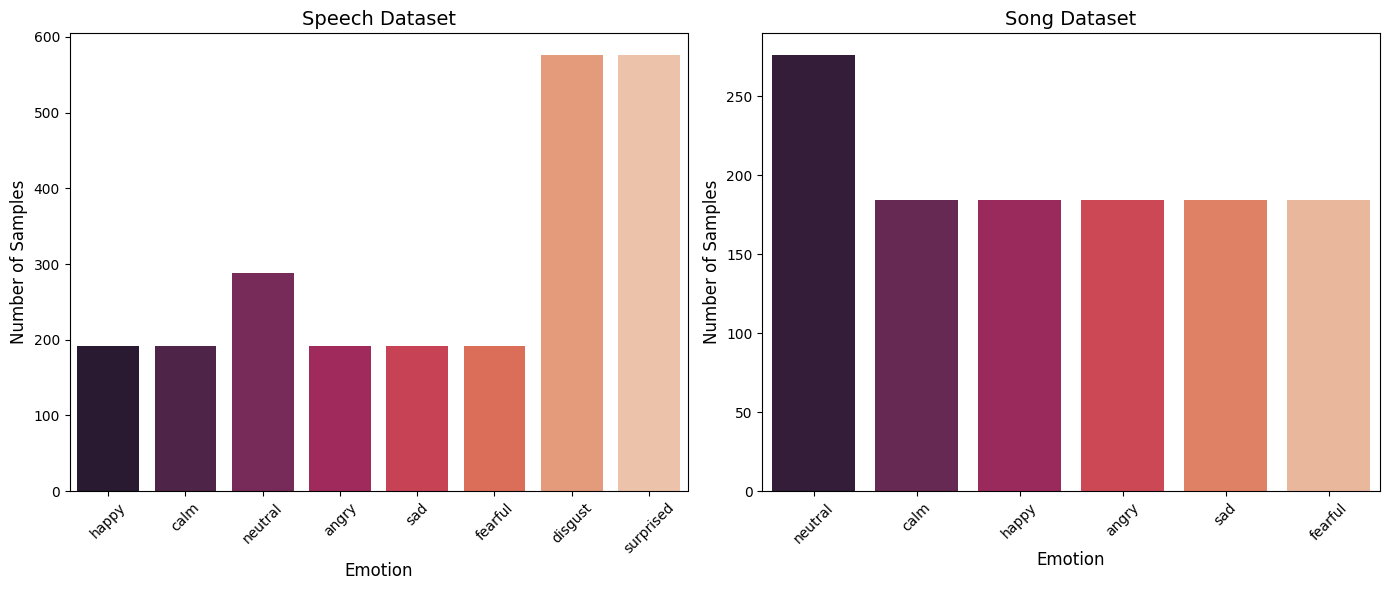

In [59]:
plt.figure(figsize=(14,6))
# Subplot 1: Speech
plt.subplot(1, 2, 1)
sns.countplot(x=y_speech, palette='rocket', hue=y_speech, legend=False)
plt.title("Speech Dataset", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)


# Subplot 2: Song
plt.subplot(1, 2, 2)
sns.countplot(x=y_song, palette='rocket', hue=y_song, legend=False)
plt.title("Song Dataset", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [60]:
X = np.vstack((X_speech, X_song))
y = np.concatenate((y_speech, y_song))

In [61]:
#Saving the extracted features
joblib.dump((X, y), "/content/drive/MyDrive/Mars_dataset/combined_dataset_augmented.joblib")

['/content/drive/MyDrive/Mars_dataset/combined_dataset_augmented.joblib']

In [62]:
X, y = joblib.load("/content/drive/MyDrive/Mars_dataset/combined_dataset_augmented.joblib")

In [63]:
print(f'\nAudio samples represented: {X.shape[0]}')
print(f'Numerical features extracted per sample: {X.shape[1]}')
features_df = pd.DataFrame(X)
features_df


Audio samples represented: 3596
Numerical features extracted per sample: 40


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-589.577576,39.144577,-16.843426,2.303287,-10.584874,-14.741841,-6.954549,-18.932184,-6.613478,-11.048788,...,-0.635096,0.976324,-0.475253,1.594438,-1.203206,1.126217,-0.286180,0.819811,-1.760366,0.787399
1,-773.592834,49.743572,-4.863748,11.883783,-3.215301,-8.119396,-11.354217,-12.689713,-5.916297,-6.789598,...,-1.234414,2.732946,2.239492,7.537683,7.514290,7.208450,2.740407,1.282220,-1.521930,1.368761
2,-750.997375,39.390350,-8.463231,12.879881,-4.865152,-9.837699,-11.141600,-13.476465,-5.659172,-6.117455,...,0.277349,5.049253,3.821136,8.263936,6.944689,7.300623,3.900487,2.128975,-0.493518,2.505819
3,-498.162994,33.618286,-41.688370,-4.331263,-21.510492,-22.606663,-12.670688,-21.356344,-12.716095,-3.604951,...,1.536126,2.702379,0.501304,0.264041,-3.263350,-0.999669,-1.482429,-0.383433,-1.585323,0.803831
4,-768.697388,45.240726,0.894592,11.376676,-1.603046,-5.501791,-10.103149,-13.460706,-4.300888,-1.279601,...,0.429498,5.086061,4.631549,9.765402,5.523167,5.665877,2.261629,2.494878,0.968712,4.738180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591,-502.721649,30.540987,-43.021839,11.120656,-20.167742,-13.500096,-6.138659,-17.629124,-10.851589,-2.831831,...,-0.841690,5.929868,1.518898,-5.272542,-3.054985,1.721771,-3.737528,-1.250605,2.923730,11.593288
3592,-419.443024,18.600313,-38.547382,5.136595,-15.849470,-17.996122,-9.713720,-19.882967,-15.570792,-1.875961,...,0.056547,4.638282,-1.077554,-3.491588,-2.369030,4.751110,-1.488995,-1.125405,4.504963,10.241462
3593,-427.619812,30.384157,-42.411541,8.106397,-17.139006,-21.408274,-5.853790,-22.190557,-13.738796,-2.393602,...,-2.566582,3.551807,-1.144861,-2.627040,-3.473150,2.632978,-0.856800,-0.769435,1.003197,6.096525
3594,-387.519348,25.708046,-47.041874,15.495656,-23.457232,-18.804970,4.071785,-20.809362,-8.414964,-4.887785,...,-3.759035,6.600002,3.869096,-2.370817,-4.380470,2.248428,0.082395,-2.475107,-1.795742,7.487014


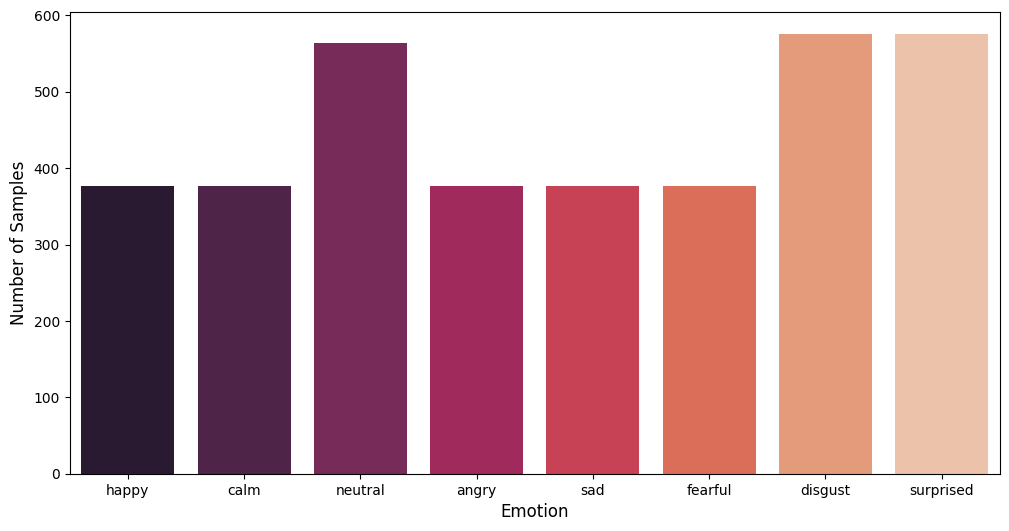

In [64]:
plt.figure(figsize=(12,6))
# emotion_list, count = np.unique(emotions, return_counts=True)
sns.countplot(x= y,palette='rocket',hue=y,legend=False)
plt.xlabel('Emotion',fontsize=12)
# plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples',fontsize=12)
plt.show()

<i>
<h2>DATA PREPROCESSING</h2>

In [95]:
# Encode emotion labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, "/content/drive/MyDrive/Mars_dataset/label_encoder.pkl")


# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "/content/drive/MyDrive/Mars_dataset/scaler.pkl")

['/content/drive/MyDrive/Mars_dataset/scaler.pkl']

In [66]:
# encoder = OneHotEncoder()
# y_encoded = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

Train-Test Split

In [68]:
# 80/20 train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    shuffle = True
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 2876
Validation samples: 720


<I>
<h2>MODEL TRAINING

In [69]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [91]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(EMOTION_MAP), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,832 (741.53 KB)

 Trainable params: 188,040 (734.53 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [72]:
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.2495 - loss: 2.4100 - val_accuracy: 0.4792 - val_loss: 1.6163 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.4663 - loss: 1.5692 - val_accuracy: 0.5208 - val_loss: 1.4465 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.4959 - loss: 1.3815 - val_accuracy: 0.5347 - val_loss: 1.3325 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.5246 - loss: 1.2319 - val_accuracy: 0.5417 - val_loss: 1.2340 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.5556 - loss: 1.1889 - val_accuracy: 0.5750 - val_loss: 1.1382 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.5953 - loss: 1.1018 - val_accuracy: 0.6083 - val_loss: 1.0683 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.6070 - loss: 1.05

In [92]:
model.save('/content/drive/MyDrive/Mars_dataset/best_model.h5')
model.save('/content/drive/MyDrive/Mars_dataset/best_model.keras')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8503 - loss: 0.4904
Validation Accuracy: 85.28%


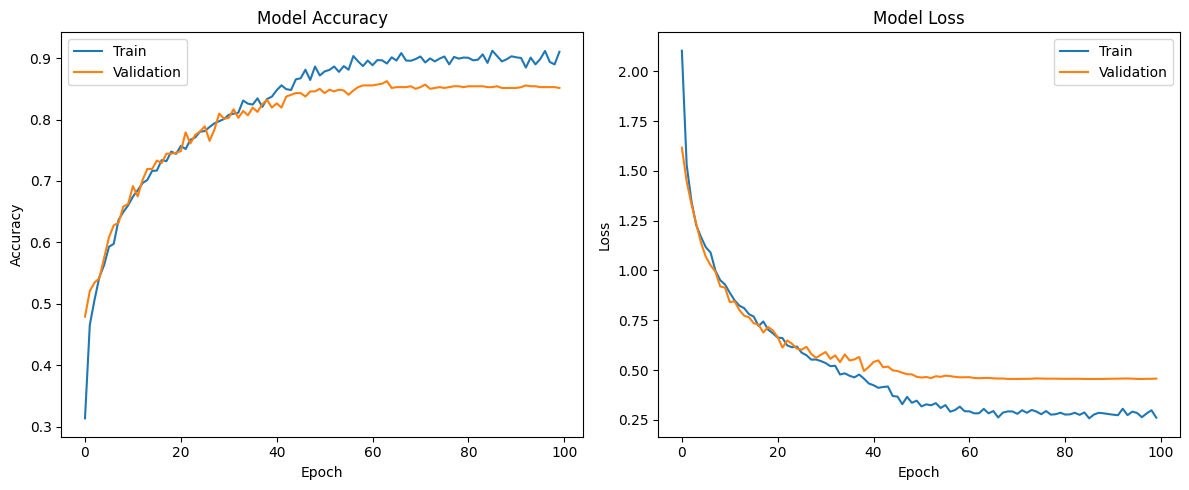

In [74]:
# Evaluate performance
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [84]:
# Predict classes and probabilities
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Overall accuracy
accuracy = accuracy_score(y_val, y_pred_classes)
print(f"Overall Accuracy: {accuracy*100:.2f}%")

# F1 scores (macro average)
f1 = f1_score(y_val, y_pred_classes, average='macro')
print(f"Macro-average F1 Score: {f1:.4f}")

# Detailed classification report
report = classification_report(
    y_val,
    y_pred_classes,
    target_names=le.classes_,
    digits=4
)
print("\nClassification Report:\n", report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Overall Accuracy: 85.28%
Macro-average F1 Score: 0.8420

Classification Report:
               precision    recall  f1-score   support

       angry     0.9589    0.8537    0.9032        82
        calm     0.8974    0.8140    0.8537        86
     disgust     0.7795    0.9340    0.8498       106
     fearful     0.7500    0.7742    0.7619        62
       happy     0.8852    0.7013    0.7826        77
     neutral     0.9076    0.9310    0.9191       116
         sad     0.8088    0.7432    0.7746        74
   surprised     0.8462    0.9402    0.8907       117

    accuracy                         0.8528       720
   macro avg     0.8542    0.8364    0.8420       720
weighted avg     0.8573    0.8528    0.8517       720



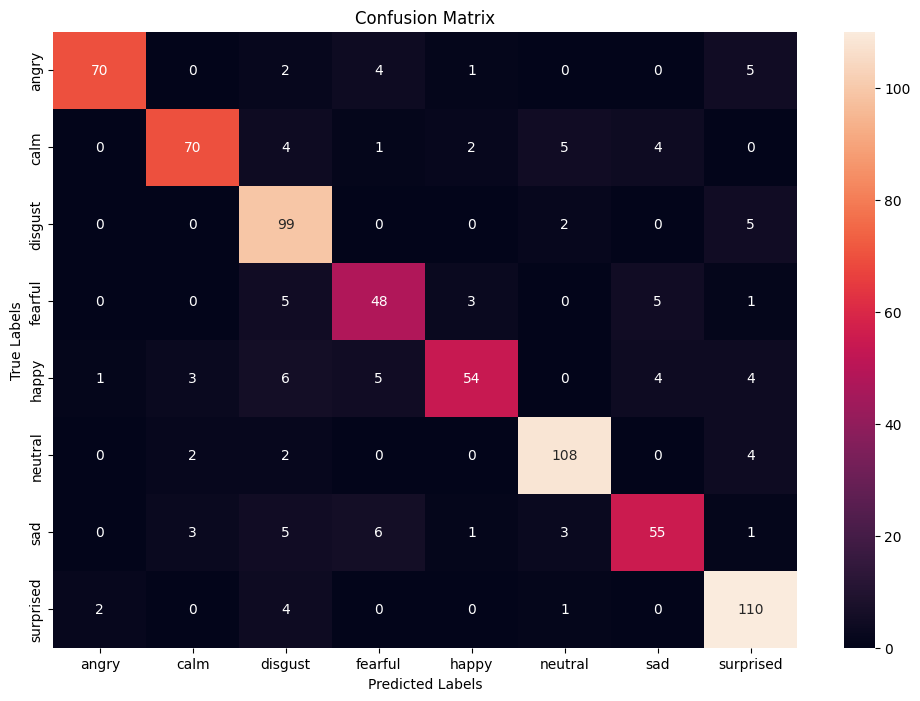

In [82]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Visualize with seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
